In [46]:
import pandas as pd

df = pd.read_csv('../Super_Dataset/data.csv', header=None, sep='|')
df.rename(columns={0: "file_name", 1: "text"}, inplace=True)
df.head()

,file_name,text
0,images/0.png,ᠲᠠᠯᠪᠢᠭᠤᠷ
1,images/1.png,ᠪᠣᠰᠤᠭᠠᠳᠠ
2,images/2.png,ᠯᠣᠭᠢᠺᠴᠢ
3,images/3.png,ᠣᠯᠣᠭᠠᠶᠢᠯᠠ
4,images/4.png,ᠪᠤᠰᠠᠭ


In [47]:
from torchvision.transforms import v2

In [48]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.1, random_state=1)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [49]:
#tfs = v2.Compose(
#    [v2.RandomRotation(degrees=10),
#    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
#    v2.RandomInvert(p=0.08),
#    #v2.JPEG(quality=(70, 100))]
#    #v2.Resize((224, 224)),
#    ]
#)

In [50]:
tfs = v2.AutoAugment(v2.AutoAugmentPolicy.IMAGENET)

In [51]:

import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, transform, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        pixel_values = self.transform(pixel_values)

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding
    

In [52]:
from transformers import ViTImageProcessor, RobertaTokenizer

img_p = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
token = RobertaTokenizer.from_pretrained('../cmn_tok/roberta/trmngbrt/')

In [53]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor(image_processor=img_p, tokenizer=token)
train_dataset = IAMDataset(root_dir='../Super_Dataset/',
                    df=train_df,
                    processor=processor,
                    transform=tfs)
eval_dataset = IAMDataset(root_dir='../Super_Dataset/',
                    df=test_df,
                    processor=processor,
                    transform=tfs)


print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))
    

Number of training examples: 161654
Number of validation examples: 17962


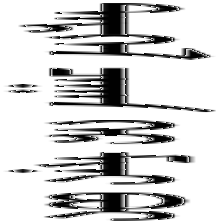

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import PIL
from PIL import Image
torchvision.transforms.ToPILImage()(train_dataset[57570]['pixel_values'])

In [55]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained('batch2/checkpoint-20208/')

In [56]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [57]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    eval_strategy="steps",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    fp16=True, 
    output_dir="./batch2/",
    logging_steps=100,
    save_steps=0.5,
    eval_steps=0.5,
    num_train_epochs=1
)

In [58]:
import evaluate

In [59]:
from datasets import load_metric

cer_metric = evaluate.load("cer")

In [60]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [61]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=token,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)


In [63]:
trainer.train()

  0%|          | 0/10104 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
!pwd

In [ ]:
model.cpu()

In [ ]:
import requests
from PIL import Image

url = "KEK1.png"
image = Image.open(url).convert("RGB")
image

In [ ]:
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)